## Load Libraries

In [2]:
import sys
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as pyplot
import ppscore as pps
import optuna
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.stats import shapiro, normaltest
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm, unit_norm, min_max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import ReLU, PReLU, LeakyReLU, ELU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop, Adamax, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, L1L2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

## Load & Prepare Data

In [3]:
df = pd.read_csv('Data/classification_testData_shape(395219,82).csv')

In [4]:
df.shape

(395219, 83)

## Split Dataset

In [4]:
X = df.drop('loan_status',axis=1)
y = df['loan_status']

In [5]:
print(X.shape, y.shape)

(395219, 82) (395219,)


In [6]:
print(X.shape[0])
print(X.shape[1])

395219
82


In [7]:
# label encode the target variable to have the classes 0 and 1 FOR BINARY CLASSIFICATION
y = LabelEncoder().fit_transform(y)

In [8]:
# one hot encode output variable FOR MULTICLASS CLASSIFICATION
#y = to_categorical(y)

# For Regression
# created scaler
#scaler = StandardScaler()
# fit scaler on training dataset
#scaler.fit(trainy)
# transform training dataset
#trainy = scaler.transform(trainy)
# transform test dataset
#testy = scaler.transform(testy)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [11]:
# FOR BINARY CLASSIFICATION
n_input = X_train.shape[1]
n_classes = len(np.unique(y_train))
num_nodes = n_input

In [12]:
# FOR MULTICLASS CLASSIFICATION
#n_input, n_classes = X_train.shape[1], y_train.shape[1]
#num_nodes = n_input

In [13]:
np.unique(y)

array([0, 1])

In [1]:
num_nodes

NameError: name 'num_nodes' is not defined

In [15]:
n_classes

2

In [16]:
(num_nodes+n_classes)//2

42

In [17]:
(num_nodes+n_classes) * (2/3)

56.0

## Normality Test

In [18]:
def is_normal(data):
    alpha = 0.05
    stat, p = normaltest(data)
    if p > alpha:
        normalTest = True
    else:
        normalTest = False
    
    stat, p = shapiro(data)
    if p > alpha:
        shapiroTest = True
    else:
        shapiroTest = False
        
    return normalTest and shapiroTest

In [19]:
Gaussian_Like = []
Non_Gaussian = []

for i, name in enumerate (X.columns):
    if is_normal(X[name]):
        Gaussian_Like.append(name)
    else:
        Non_Gaussian.append(name)
        
print (f"Gaussian Like columns: {Gaussian_Like}")
print (f"Non-Gaussian Like columns: {Non_Gaussian}")

Z:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Gaussian Like columns: []
Non-Gaussian Like columns: ['Unnamed: 0', 'loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'OTHER', 'OWN', 'RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'application_type_INDIVIDUAL', 'application_type_JOINT', 'initial_list_status_w', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'issue_month', 'issue_year', 'cr_month', 'cr_year', '05113', '11650', '22690', '29597', '

## Baseline Model

In [18]:
def create_baseline_model():
    # create model
    model = Sequential()
    #Input Layer
    model.add(Input(shape=(n_input,)))
    #Hidden Layers
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [22]:
init_time = datetime.now()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Baseline: 88.48% (0.15%)
Execution time :  7:13:16.131950


## Hyperparameter Tunning with HyperOpt

In [ ]:
params = dict()
params['layers'] = hp.choice('layers', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
params['units'] = hp.choice('units', [16, 32, 64, 128])
params['batch_size'] = hp.choice('batch_size', [16, 32, 64, 128, 256, 512])
params['optimizer'] = hp.choice('optimizer', [SGD(), RMSprop(), Adagrad(), Adam(), Adamax(), Nadam()])
params['activation']= hp.choice('activation', [ReLU(), PReLU(), LeakyReLU(), ELU()])
params['learning_rate'] = hp.uniform('learning_rate',1e-7, 1.0)
params['init_mode']= hp.choice('init_mode', 
['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
params['dropout_rate']= hp.choice('dropout_rate', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
params['weight_constraint'] = hp.choice('weight_constraint',
                            [unit_norm(), max_norm(1), max_norm(2), max_norm(3), max_norm(4), max_norm(5)])

In [ ]:
norm = MinMaxScaler()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)
X_valid = norm.transform(X_valid)

In [ ]:
best_score = 0
best_param = []
testing = 1

In [ ]:
def hyperparameters(params):  
    global best_score
    global testing
    
    #print (f'Testing - {testing}: {params}')
    #create model
    model = Sequential()
    #Input Layer
    model.add(Input(shape=(n_input,)))
    
    #Hidden Layers  
    for i in range(params['layers']):
        model.add(Dense(units=params['units'], kernel_initializer=params['init_mode'], 
                        activation=params['activation'], 
                        kernel_constraint=params['weight_constraint']))
        model.add(Dropout(params['dropout_rate']))
        #model.add(BatchNormalization())
    
    #Output Layer
    model.add(Dense(1, activation='sigmoid'))
    #Compile model
    optimizer = params['optimizer']
    optimizer.learning_rate=params['learning_rate'];
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()  
    
    model.fit(x=X_train, 
              y=y_train, 
              epochs=1000,
              batch_size=params['batch_size'],
              validation_data=(X_valid, y_valid), 
              #validation_split=0.2, 
              verbose=0,
              callbacks=[early_stop]
             )

    pred_auc =model.predict(X_test, batch_size = params['batch_size'], verbose = 0)
    acc = roc_auc_score(y_test, pred_auc) #accuracy_score roc_auc_score
    testing = testing + 1
    if best_score==0:
        best_score=acc
    if acc > best_score:
        best_score=acc
        best_param=params
        print(f'BEST AUC:{best_score:.4f}')
        print (f'BEST PARAMS: {testing} -> {params}')
        
    #sys.stdout.flush() 
    return {'loss': acc, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameters,
            space=params,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

In [ ]:
print (f"Best Score: {best_score}")
print (f"Best Params: {best_param}")

In [ ]:
loss = trials.best_trial['result']['loss']
print ('loss :', loss)
model = trials.best_trial['result']['model']
print (model)

### 1-2. Tune Batch Size and Number of Epochs

In [49]:
def create_model():
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu'))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    #sgd = SGD(lr=0.01, momentum=0.8)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [50]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, verbose=0)))
pipeline = Pipeline(estimators)

In [52]:
init_time = datetime.now()
# create model
#model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__batch_size': (16, 32, 64, 128, 256, 512),
    'mlp__epochs': (100, 150, 200, 250, 300, 350)
}
#batch_size = [16, 32, 64, 128, 256, 512]
#epochs = [50, 100, 150, 200, 200, 250, 300]
#param_grid = dict(batch_size=batch_size, epochs=epochs)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.884988 using {'mlp__batch_size': 512, 'mlp__epochs': 50}
0.876638 (0.003409) with: {'mlp__batch_size': 16, 'mlp__epochs': 50}
0.864177 (0.004338) with: {'mlp__batch_size': 16, 'mlp__epochs': 100}
0.860116 (0.003607) with: {'mlp__batch_size': 16, 'mlp__epochs': 150}
0.858155 (0.002768) with: {'mlp__batch_size': 16, 'mlp__epochs': 200}
0.860837 (0.001818) with: {'mlp__batch_size': 16, 'mlp__epochs': 200}
0.855157 (0.001381) with: {'mlp__batch_size': 16, 'mlp__epochs': 250}
0.854638 (0.002760) with: {'mlp__batch_size': 16, 'mlp__epochs': 300}
0.869490 (0.002094) with: {'mlp__batch_size': 32, 'mlp__epochs': 50}
0.857446 (0.006471) with: {'mlp__batch_size': 32, 'mlp__epochs': 100}
0.853892 (0.004657) with: {'mlp__batch_size': 32, 'mlp__epochs': 150}
0.851564 (0.004904) with: {'mlp__batch_size': 32, 'mlp__epochs': 200}
0.852917 (0.001733) with: {'mlp__batch_size': 32, 'mlp__epochs': 200}
0.847073 (0.003577) with: {'mlp__batch_size': 32, 'mlp__epochs': 250}
0.845694 (0.002205) with: {

### 3. Tune the Training Optimization Algorithm

In [19]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu'))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [20]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [21]:
init_time = datetime.now()
# create model
# model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__optimizer': ('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')
}
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#param_grid = dict(optimizer=optimizer)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889479 using {'mlp__optimizer': 'Adagrad'}
0.884963 (0.002223) with: {'mlp__optimizer': 'SGD'}
0.887594 (0.002305) with: {'mlp__optimizer': 'RMSprop'}
0.889479 (0.000944) with: {'mlp__optimizer': 'Adagrad'}
0.888530 (0.001181) with: {'mlp__optimizer': 'Adadelta'}
0.848768 (0.004870) with: {'mlp__optimizer': 'Adam'}
0.869161 (0.000882) with: {'mlp__optimizer': 'Adamax'}
0.847566 (0.001521) with: {'mlp__optimizer': 'Nadam'}
Execution time :  2:34:12.603498


### 4-5. Tune Learning Rate and Momentum

In [23]:
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu'))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    #optimizer = SGD(lr=learn_rate, momentum=momentum)
    optimizer = Adagrad(learning_rate=learn_rate)
    #optimizer.learning_rate=learn_rate;
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [25]:
init_time = datetime.now()
# create model
# model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__learn_rate': (0.0001, 0.001, 0.01, 0.1, 0.2, 0.3)
}
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#param_grid = dict(learn_rate=learn_rate, momentum=momentum)
#param_grid = dict(learn_rate=learn_rate)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889302 using {'mlp__learn_rate': 0.001}
0.889302 (0.001483) with: {'mlp__learn_rate': 0.001}
0.884406 (0.002373) with: {'mlp__learn_rate': 0.01}
0.851349 (0.004219) with: {'mlp__learn_rate': 0.1}
0.844896 (0.003451) with: {'mlp__learn_rate': 0.2}
0.846503 (0.003708) with: {'mlp__learn_rate': 0.3}
Execution time :  1:37:40.910201


### 6. Tune Network Kernel/Weight Initialization

In [26]:
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, kernel_initializer=init_mode, activation='relu'))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, kernel_initializer=init_mode, activation='relu'))
    # Output Layer
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [27]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [28]:
init_time = datetime.now()
# create model
#model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__init_mode': ('uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform')
}
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#param_grid = dict(init_mode=init_mode)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889454 using {'mlp__init_mode': 'uniform'}
0.889454 (0.002410) with: {'mlp__init_mode': 'uniform'}
0.889264 (0.002288) with: {'mlp__init_mode': 'lecun_uniform'}
0.889289 (0.002312) with: {'mlp__init_mode': 'normal'}
0.804906 (0.000025) with: {'mlp__init_mode': 'zero'}
0.889176 (0.002344) with: {'mlp__init_mode': 'glorot_normal'}
0.889062 (0.002333) with: {'mlp__init_mode': 'glorot_uniform'}
0.888973 (0.002088) with: {'mlp__init_mode': 'he_normal'}
0.888708 (0.002065) with: {'mlp__init_mode': 'he_uniform'}
Execution time :  2:23:11.523127


### 7. Tune the Activation Function

In [33]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation=activation))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation=activation))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [34]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [39]:
init_time = datetime.now()
# create model
# model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# define the grid search parameters  ReLU, PReLU, LeakyReLU, ELU
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__activation': ('relu', 'prelu', 'leakyrelu', 'elu')
}
#activation = ['relu', 'LReLU', 'PReLU', 'elu']
#param_grid = dict(activation=activation)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889479 using {'mlp__activation': 'relu'}
0.889479 (0.001221) with: {'mlp__activation': 'relu'}
nan (nan) with: {'mlp__activation': 'prelu'}
nan (nan) with: {'mlp__activation': 'leakyrelu'}
0.889252 (0.001135) with: {'mlp__activation': 'elu'}
Execution time :  0:42:57.677364


### 8-9. Tune Activity Regularization (L1) & Weight Regularization (L2) 

A modern recommendation for regularization is to use early stopping with dropout and a weight constraint.

In [19]:
# Function to create model, required for KerasClassifier
def create_model(l1=0.0, l2=0.0):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu', 
                     kernel_regularizer=L1L2(l1=l1, l2=l2)))
    model.add(Dropout(0.2))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu'))
    model.add(Dropout(0.2))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [20]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [21]:
init_time = datetime.now()
# create model
#model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__l1': (0.100000, 0.010000, 0.001000, 0.000100, 0.000010, 0.000001, 0.0),
    'mlp__l2': (0.100000, 0.010000, 0.001000, 0.000100, 0.000010, 0.000001, 0.0)
}
#l1 = [0.100000, 0.010000, 0.001000, 0.000100, 0.000010, 0.000001, 0.0]
#l2 = [0.100000, 0.010000, 0.001000, 0.000100, 0.000010, 0.000001, 0.0]
#param_grid = dict(l1=l1, l2=l2)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889353 using {'mlp__l1': 0.0001, 'mlp__l2': 0.0}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 0.1}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 0.01}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 0.001}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 0.0001}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 1e-05}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 1e-06}
0.804906 (0.000025) with: {'mlp__l1': 0.1, 'mlp__l2': 0.0}
0.888303 (0.001864) with: {'mlp__l1': 0.01, 'mlp__l2': 0.1}
0.888923 (0.001714) with: {'mlp__l1': 0.01, 'mlp__l2': 0.01}
0.888733 (0.001696) with: {'mlp__l1': 0.01, 'mlp__l2': 0.001}
0.888720 (0.001735) with: {'mlp__l1': 0.01, 'mlp__l2': 0.0001}
0.888897 (0.001674) with: {'mlp__l1': 0.01, 'mlp__l2': 1e-05}
0.888897 (0.001674) with: {'mlp__l1': 0.01, 'mlp__l2': 1e-06}
0.888897 (0.001674) with: {'mlp__l1': 0.01, 'mlp__l2': 0.0}
0.888758 (0.001955) with: {'mlp__l1': 0.001, 'mlp__l2': 0.1}
0.888644 (0.002058) with: {'m

### 10-11. Tune Dropout Regularization and Weight Constraint

* Early stopping should be used almost universally.
* The constraints are specified per-layer,

In [27]:
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu', 
                    kernel_constraint=max_norm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu', kernel_constraint=max_norm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [28]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [29]:
init_time = datetime.now()
# create model
# model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__dropout_rate': (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
    'mlp__weight_constraint': (1, 2, 3, 4, 5)
}
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889593 using {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 1}
0.889593 (0.001632) with: {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 1}
0.889479 (0.001832) with: {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 2}
0.889441 (0.001793) with: {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 3}
0.889492 (0.002170) with: {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 4}
0.889176 (0.001563) with: {'mlp__dropout_rate': 0.0, 'mlp__weight_constraint': 5}
0.889087 (0.002129) with: {'mlp__dropout_rate': 0.1, 'mlp__weight_constraint': 1}
0.888910 (0.001595) with: {'mlp__dropout_rate': 0.1, 'mlp__weight_constraint': 2}
0.888986 (0.002102) with: {'mlp__dropout_rate': 0.1, 'mlp__weight_constraint': 3}
0.889036 (0.001986) with: {'mlp__dropout_rate': 0.1, 'mlp__weight_constraint': 4}
0.889201 (0.001874) with: {'mlp__dropout_rate': 0.1, 'mlp__weight_constraint': 5}
0.889290 (0.001738) with: {'mlp__dropout_rate': 0.2, 'mlp__weight_constraint': 1}
0.889074 (0.001925) w

### 12. Tune with Batch Normalization

In [53]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(num_nodes, input_dim=n_input, activation='relu'))
    model.add(BatchNormalization())
    # Hidden Layers
    model.add(Dense((num_nodes+1)//2, activation='relu'))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [54]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [55]:
init_time = datetime.now()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(pipeline, X_test, y_test, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Baseline: 88.75% (0.20%)
Execution time :  0:45:37.850725


### 13. Tune the Number of Neurons in the Hidden Layer

In [20]:
# Function to create model, required for KerasClassifier
def create_model(neurons=num_nodes):
    # create model
    model = Sequential()
    # Input + Hidden Layers
    model.add(Dense(neurons, input_dim=n_input, activation='relu', 
                    kernel_constraint=max_norm(1)))
    model.add(Dropout(0.0))
    # Hidden Layers
    model.add(Dense((neurons+1)//2, activation='relu'))
    model.add(Dropout(0.0))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [21]:
estimators = []
estimators.append(('norm', MinMaxScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

In [22]:
init_time = datetime.now()
# create model
#model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=32, verbose=0)
# define the grid search parameters
param_grid = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'mlp__neurons': (512, 256, 128, 64, 32, 16)
}
#neurons = [512, 256, 128, 64, 32, 16]
#param_grid = dict(neurons=neurons)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Best: 0.889631 using {'mlp__neurons': 128}
0.889252 (0.002310) with: {'mlp__neurons': 512}
0.888935 (0.002385) with: {'mlp__neurons': 256}
0.889631 (0.002567) with: {'mlp__neurons': 128}
0.889429 (0.002557) with: {'mlp__neurons': 64}
0.889062 (0.002145) with: {'mlp__neurons': 32}
0.889037 (0.002306) with: {'mlp__neurons': 16}
Execution time :  3:16:54.855942


### Parameters

* A modern recommendation for regularization is to use early stopping with dropout and a weight constraint instead of l1 & l2.
* The constraints (weight_constraint) are specified per-layer
* Early stopping should be used almost universally.

In [18]:
callbacks_list = []
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
callbacks_list.append(early_stop)

In [19]:
params = dict()
#params['epochs'] = [1000]
#params['validation_data']=[(X_test, y_test)],
#params['callbacks']= early_stop,
params['batch_size'] = hp.choice('batch_size', [16, 32, 64, 128, 256, 512])
#params['neurons']= [16, 32, 64, 128, 256, 512]
params['optimizer'] = hp.choice('optimizer', [SGD(), RMSprop(), Adagrad(), Adam(), Adamax(), Nadam()])
params['activation']= hp.choice('activation', [ReLU(), PReLU(), LeakyReLU(), ELU()])
params['learning_rate'] = hp.uniform('learning_rate',1e-7, 1.0)
params['init_mode']= hp.choice('init_mode', 
['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
params['dropout_rate']= hp.choice('dropout_rate', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
params['weight_constraint'] = hp.choice('weight_constraint',
                            [unit_norm(), max_norm(1), max_norm(2), max_norm(3), max_norm(4), max_norm(5)])

#params['l1'] = hp.uniform('l1', 0, 0.1)
#params['l2'] = hp.uniform('l2', 0, 0.1)

### HyperOpt Optimization

Hyperopt functions for optimization:

    hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
    hp.randint(label, upper) — Returns a random integer between the range [0, upper).
    hp.uniform(label, low, high) — Returns a value uniformly between low and high.
    hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer
    hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [20]:
best_score = 0
best_param = []

In [25]:
def hyperparameters(params):  
    global best_score
    
    #print ('Params testing: ', params)
    # create model
    model = Sequential()
    # Input Layer
    model.add(Input(shape=(n_input,)))
    #Hidden Layers  
    model.add(Dense(num_nodes, kernel_initializer=params['init_mode'], activation=params['activation'], 
                    kernel_constraint=params['weight_constraint']))
    model.add(Dropout(params['dropout_rate']))
    #model.add(BatchNormalization())
    # Hidden Layers
    model.add(Dense(num_nodes, kernel_initializer=params['init_mode'], activation=params['activation'],
                   kernel_constraint=params['weight_constraint']))
    model.add(Dropout(params['dropout_rate']))
    #model.add(BatchNormalization())
    # Output Layer
    model.add(Dense(1, kernel_initializer=params['init_mode'], activation='sigmoid'))
    # Compile model
    optimizer = params['optimizer']
    optimizer.learning_rate=params['learning_rate'];
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()  
    
    model.fit(x=X_train, 
              y=y_train, 
              epochs=1000,
              batch_size=params['batch_size'],
              validation_data=(X_valid, y_valid), 
              verbose=0,
              callbacks=callbacks_list
             )

    #model.fit(X_train,y_train,epochs=params['epochs'],validation_data=(X_test,y_test), batch_size = 32,verbose=0)

    pred_auc =model.predict(X_test, batch_size = params['batch_size'], verbose = 0)
    acc = roc_auc_score(y_test, pred_auc)
    if best_score==0:
        best_score=acc
    if acc > best_score:
        best_score=acc
        best_param=params
        print(f'AUC:{best_score:.4f}')
        print("PARAMS: ", paramas)
    sys.stdout.flush() 
    return {'loss': acc, 'status': STATUS_OK, 'model': model}

In [26]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
trials = Trials()
best = fmin(fn=hyperparameters,
            space=params,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2020-11-29 01:59:49.616154
Model: "sequential_7"                                                                                                               
_________________________________________________________________                                                                   
Layer (type)                 Output Shape              Param #                                                                      
dense_19 (Dense)             (None, 82)                6806                                                                         
_________________________________________________________________                                                                   
dropout_12 (Dropout)         (None, 82)                0                                                                            
_________________________________________________________________                                                                   
dense_20 (Dense)          

dense_38 (Dense)             (None, 82)                6888                                                                         
_________________________________________________________________                                                                   
dropout_25 (Dropout)         (None, 82)                0                                                                            
_________________________________________________________________                                                                   
dense_39 (Dense)             (None, 1)                 83                                                                           
Total params: 13,777                                                                                                                
Trainable params: 13,777                                                                                                            
Non-trainable params: 0                                              

Non-trainable params: 0                                                                                                             
_________________________________________________________________                                                                   
Epoch 00047: early stopping                                                                                                         
Model: "sequential_20"                                                                                                              
_________________________________________________________________                                                                   
Layer (type)                 Output Shape              Param #                                                                      
dense_58 (Dense)             (None, 82)                6806                                                                         
_________________________________________________________________    

job exception: name 'paramas' is not defined



 13%|████████▉                                                            | 13/100 [2:03:18<13:45:10, 569.09s/trial, best loss: 0.5]


NameError: name 'paramas' is not defined

In [ ]:
print (f"Best Score: {best_score}")
print (f"Best Params: {best_param}")

In [ ]:
loss = trials.best_trial['result']['loss']
print ('loss :', loss)
model = trials.best_trial['result']['model']
print (model)

### skopt Optimization

In [35]:
params = dict()
params['epochs'] = [1000]
params['validation_data']=[(X_test, y_test)],
params['callbacks']= early_stop,
params['batch_size'] = [16, 32, 64, 128, 256, 512]
#params['neurons']= [16, 32, 64, 128, 256, 512]
params['optimizer'] = [SGD(), RMSprop(), Adagrad(), Adam(), Adamax(), Nadam()]
params['activation']= [ReLU(), PReLU(), LeakyReLU(), ELU()]
params['learning_rate'] = (1e-7, 1.0)
params['init_mode']= 
['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
params['l1'] = (0, 0.1)
params['l2'] = (0, 0.1)
#params['dropout_rate']= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#params['weight_constraint'] = [1, 2, 3, 4, 5]

82

In [52]:
# Function to create model, required for KerasClassifier
#dropout_rate=0.0, weight_constraint=0
#kernel_constraint=max_norm(weight_constraint)
#learn_rate=0.01
def create_model(neurons=num_nodes, activation=ReLU(), optimizer=Adam(), learning_rate=0.01, init_mode='uniform', 
                 l1=0.0, l2=0.0):
    # create model
    model = Sequential()
    # Input Layer
    model.add(Input(shape=(n_input,)))
    #Hidden Layers  
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, 
                    kernel_regularizer=L1L2(l1=l1, l2=l2)))
    #model.add(Dropout(0.0))
    model.add(BatchNormalization())
    # Hidden Layers
    model.add(Dense((neurons+1)//2, kernel_initializer=init_mode, activation=activation))
    #model.add(Dropout(0.0))
    model.add(BatchNormalization())
    # Output Layer
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    optimizer.learning_rate=learning_rate;
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [56]:
mlp_model = KerasClassifier(build_fn=create_model, verbose=0)

In [57]:
search = BayesSearchCV(estimator=mlp_model, search_spaces=params, n_jobs=-1) 

In [58]:
# callback handler
def on_step(optim_result):
    score = search.best_score_
    print (f"{datetime.now()}: Best Score- {score:.4f}")
    print (f"Best Params- {search.best_params_}")
    if score >= 0.98:
        print('Interrupting!')
        return True

In [59]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# perform the search
search.fit(X_train, y_train, callback=on_step) 
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2020-11-27 19:06:43.432621
2020-11-28 00:40:11.624274: Best Score- 0.7786
2020-11-28 03:12:48.363644: Best Score- 0.8042
2020-11-28 11:02:11.661192: Best Score- 0.8042


ValueError: Dimensions must be equal, but are 64 and 32 for '{{node dense_10/p_re_lu_4/mul}} = Mul[T=DT_FLOAT](dense_10/p_re_lu_4/Neg, dense_10/p_re_lu_4/Relu_1)' with input shapes: [64], [?,32].

In [ ]:
# report the best result
print(search.best_score_)
print(search.best_params_)

### Keras Tuner

In [18]:
from kerastuner import HyperParameters
from kerastuner import HyperModel
from kerastuner import BayesianOptimization

In [19]:
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', \
             'glorot_uniform', 'he_normal', 'he_uniform']

In [25]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',
                                 min_value=80,
                                 max_value=256,
                                 step=16),
                    input_dim=n_input,
                    kernel_initializer=hp.Choice('init_mode', init_mode),
                    activation='relu'
                    #activation=hp.Choice('activation', ['relu', 'tanh'])
                    )
             )
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                     min_value=80,
                                     max_value=256,
                                     step=16),
                        kernel_initializer=hp.Choice('init_mode_' + str(i), init_mode),
                        activation='relu'
                        #activation=hp.Choice('activation', ['relu', 'tanh'])
                       )
                 )
        model.add(Dropout(hp.Float('dropout_' + str(i),
                                   min_value=0.0,
                                   max_value=1.0,
                                   step=0.1
                                  )
                         )
                 )
        #model.add(BatchNormalization())
    #[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [26]:
tuner_bo = BayesianOptimization(
            build_model,
            objective='accuracy',
            max_trials=10,
            seed=42,
            executions_per_trial=2
        )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [28]:
tuner_bo.search(X_train, y_train, validation_data=(X_valid, y_valid), 
                epochs=10000, batch_size=32, verbose=1,
                callbacks=[early_stop])

INFO:tensorflow:Oracle triggered exit


In [29]:
best_model = tuner_bo.get_best_models(num_models=1)[0]

In [31]:
best_model.evaluate(X_test, y_test)

3706/3706 [==============================] - 4s 1ms/step - loss: 0.4945 - accuracy: 0.8042


[0.4944514036178589, 0.8042440414428711]

In [32]:
best_model.fit(x=X_train, 
               y=y_train, 
               epochs=1000,
               batch_size=32,
               validation_data=(X_valid, y_valid), verbose=1,
               callbacks=[early_stop])

Epoch 1/1000
6052/6052 [==============================] - 15s 2ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 2/1000
6052/6052 [==============================] - 17s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 3/1000
6052/6052 [==============================] - 17s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 4/1000
6052/6052 [==============================] - 17s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 5/1000
6052/6052 [==============================] - 17s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 6/1000
6052/6052 [==============================] - 17s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0.4966 - val_accuracy: 0.8027
Epoch 7/1000
6052/6052 [==============================] - 16s 3ms/step - loss: 0.4947 - accuracy: 0.8041 - val_loss: 0

In [33]:
predictions = best_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     95356
           1       0.00      0.00      0.00     23210

    accuracy                           0.80    118566
   macro avg       0.40      0.50      0.45    118566
weighted avg       0.65      0.80      0.72    118566



/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multilayer Perceotron (MLP) Model

### Common Methods

In [17]:
def evaluate_model(X_train, y_train, X_valid, y_valid, model, optimizer):
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_valid, y_valid, verbose=0)
    
    print(f"Optimizer: {optimizer} Training Loss: {train_acc:.3f} Validation Accuracy:{test_acc:.3f}")
    
# evaluate the Regression model
#train_mse = model.evaluate(trainX, trainy, verbose=0)
#test_mse = model.evaluate(testX, testy, verbose=0)

In [18]:
def plot_loss(history, optimizer):
    # plot loss during training
    pyplot.figure(figsize=(15,10))
    pyplot.subplot(211) 
    pyplot.title(f"Binary Cross-Entropy Loss of optimizer {optimizer}" , pad=-20)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()

In [19]:
def plot_accuracy(history, optimizer):
    # plot accuracy during training
    pyplot.figure(figsize=(15,10))
    pyplot.subplot(212)
    pyplot.title(f"Classification Accuracy of optimizer {optimizer}" , pad=-20)
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()

In [20]:
callbacks_list = []

In [21]:
# checkpoint
#filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath="weights.best.hdf5" # Checkpoint Best Neural Network Model Only
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list.append(checkpoint)

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
callbacks_list.append(early_stop)

In [23]:
# create learning curves for different optimizers
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adam']

### Experiment with Dropout + kernel_constraint(max_norm)

In [122]:
def create_experiment_model(hidden_layer=3, optimizer='adam'):
    # create model
    model = Sequential()
    # Input Layer
    model.add(Dropout(0.2, input_shape=(n_input,)))
    
    # grid search values
    #values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    #model.add(Dense(500, input_dim=2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    
    # Hidden Layers
    if hidden_layer==1:
        model.add(Dense(82, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
        
    if hidden_layer==2:
        model.add(Dense(82, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
        
        model.add(Dense(41, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
    
    if hidden_layer==3:
        model.add(Dense(82, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
        
        model.add(Dense(41, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
        
        model.add(Dense(21, activation='relu', kernel_constraint=max_norm(3)))
        model.add(Dropout(0.2))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

### Experiment with adam + 3 hidden layer

In [219]:
init_time = datetime.now()
model = create_experiment_model()
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7897/7905 [============================>.] - ETA: 0s - loss: 49.7820 - accuracy: 0.7846
Epoch 00001: val_accuracy improved from -inf to 0.80109, saving model to weights.best.hdf5
7905/7905 [==============================] - 9s 1ms/step - loss: 49.7361 - accuracy: 0.7846 - val_loss: 0.4989 - val_accuracy: 0.8011
Epoch 2/600
7903/7905 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.8041
Epoch 00002: val_accuracy did not improve from 0.80109
7905/7905 [==============================] - 9s 1ms/step - loss: 0.5144 - accuracy: 0.8041 - val_loss: 0.4989 - val_accuracy: 0.8011
Epoch 3/600
7899/7905 [============================>.] - ETA: 0s - loss: 0.4967 - accuracy: 0.8042
Epoch 00003: val_accuracy did not improve from 0.80109
7905/7905 [==============================] - 9s 1ms/step - loss: 0.4967 - accuracy: 0.8042 - val_loss: 0.4989 - val_accuracy: 0.8011
Epoch 4/600
7903/7905 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.8042
Ep

In [220]:
evaluate_model(X_train, y_train, X_valid, y_valid, model, optimizers[3])

Optimizer: adam Train: 0.804 Test:0.801


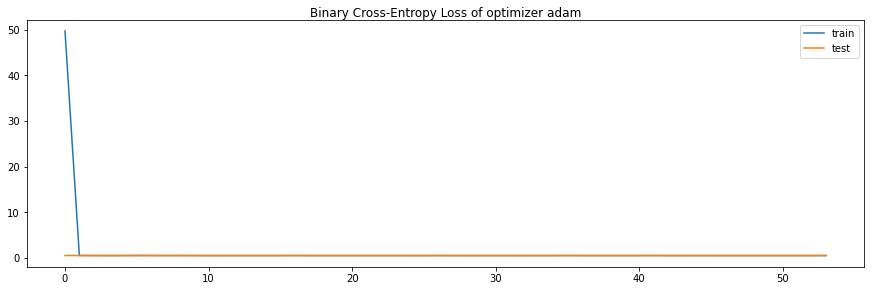

In [221]:
plot_loss(history, optimizers[3])

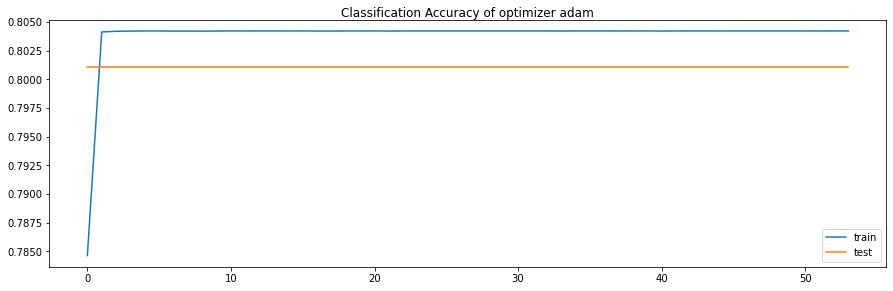

In [222]:
plot_accuracy(history, optimizers[3])

### Experiment with Stabilize Learning with Data Scaling (Normalization)

In [26]:
norm_scaler = MinMaxScaler()
norm_scaler.fit(X_train)

X_train_norm = norm_scaler.transform(X_train)
X_test_norm = norm_scaler.transform(X_test)
X_valid_norm = norm_scaler.transform(X_valid)

In [224]:
init_time = datetime.now()
model = create_experiment_model()
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7878/7905 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8693
Epoch 00001: val_accuracy improved from 0.80109 to 0.88693, saving model to weights.best.hdf5
7905/7905 [==============================] - 8s 955us/step - loss: 0.3309 - accuracy: 0.8693 - val_loss: 0.2777 - val_accuracy: 0.8869
Epoch 2/600
7903/7905 [============================>.] - ETA: 0s - loss: 0.3208 - accuracy: 0.8716
Epoch 00002: val_accuracy did not improve from 0.88693
7905/7905 [==============================] - 7s 908us/step - loss: 0.3208 - accuracy: 0.8716 - val_loss: 0.2769 - val_accuracy: 0.8869
Epoch 3/600
7877/7905 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.8717
Epoch 00003: val_accuracy did not improve from 0.88693
7905/7905 [==============================] - 9s 1ms/step - loss: 0.3199 - accuracy: 0.8717 - val_loss: 0.2795 - val_accuracy: 0.8869
Epoch 4/600
7888/7905 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.87

Epoch 29/600
7861/7905 [============================>.] - ETA: 0s - loss: 0.3193 - accuracy: 0.8710
Epoch 00029: val_accuracy did not improve from 0.88720
7905/7905 [==============================] - 10s 1ms/step - loss: 0.3193 - accuracy: 0.8710 - val_loss: 0.2787 - val_accuracy: 0.8869
Epoch 30/600
7871/7905 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8715
Epoch 00030: val_accuracy did not improve from 0.88720
7905/7905 [==============================] - 9s 1ms/step - loss: 0.3188 - accuracy: 0.8714 - val_loss: 0.2780 - val_accuracy: 0.8870
Epoch 31/600
7891/7905 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8713
Epoch 00031: val_accuracy did not improve from 0.88720
7905/7905 [==============================] - 9s 1ms/step - loss: 0.3188 - accuracy: 0.8713 - val_loss: 0.2772 - val_accuracy: 0.8869
Epoch 32/600
7867/7905 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.8713
Epoch 00032: val_accuracy did not i

In [225]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Train: 0.888 Test:0.887


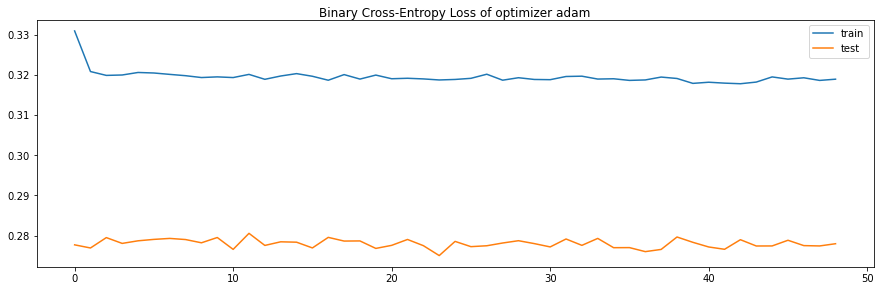

In [226]:
plot_loss(history, optimizers[3])

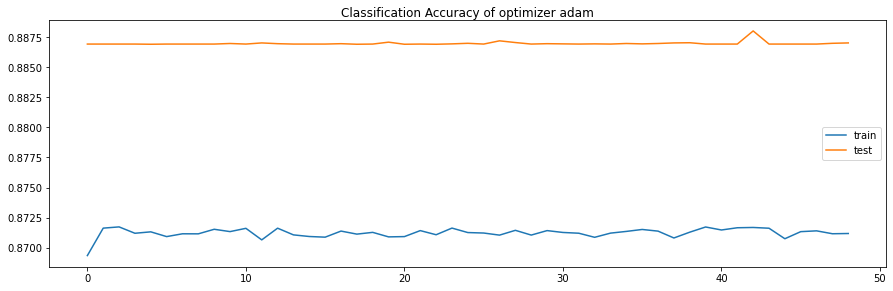

In [227]:
plot_accuracy(history, optimizers[3])

### Experiment with Stabilize Learning with Data Scaling (Standardization)

In [228]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)

X_train_std = standard_scaler.transform(X_train)
X_test_std = standard_scaler.transform(X_test)
X_valid_std = standard_scaler.transform(X_valid)

In [229]:
init_time = datetime.now()
model = create_experiment_model()
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32, 
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7881/7905 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.8692
Epoch 00001: val_accuracy did not improve from 0.88802
7905/7905 [==============================] - 8s 1ms/step - loss: 0.3328 - accuracy: 0.8692 - val_loss: 0.2802 - val_accuracy: 0.8869
Epoch 2/600
7897/7905 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8710
Epoch 00002: val_accuracy did not improve from 0.88802
7905/7905 [==============================] - 9s 1ms/step - loss: 0.3231 - accuracy: 0.8710 - val_loss: 0.2793 - val_accuracy: 0.8869
Epoch 3/600
7867/7905 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8711
Epoch 00003: val_accuracy did not improve from 0.88802
7905/7905 [==============================] - 9s 1ms/step - loss: 0.3215 - accuracy: 0.8712 - val_loss: 0.2786 - val_accuracy: 0.8869
Epoch 4/600
7867/7905 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8712
Epoch 00004: val_accuracy did not improv

In [230]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Train: 0.888 Test:0.887


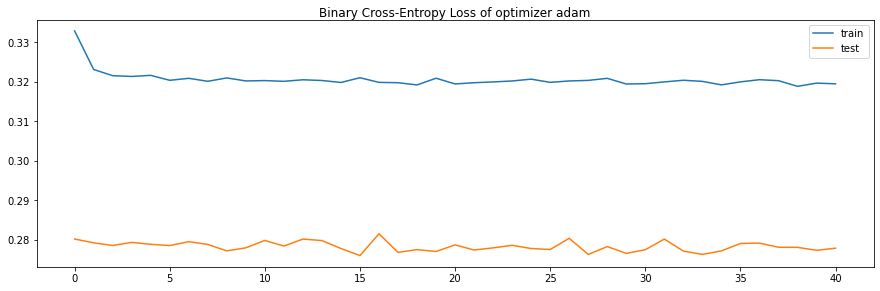

In [231]:
plot_loss(history, optimizers[3])

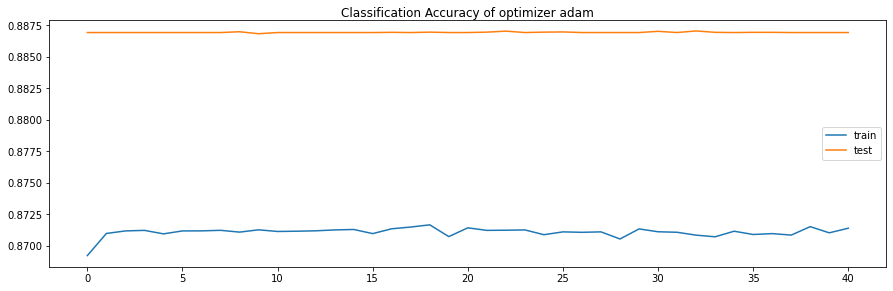

In [232]:
plot_accuracy(history, optimizers[3])

### Experiment with Accelerate Learning with Batch Normalization

In [32]:
def create_batch_normalization_model(optimizer):
    # create model
    model = Sequential()
   
    # Hidden Layers
    #model.add(Dense(82, activation='relu', kernel_initializer='he_uniform', kernel_constraint=max_norm(3)))
    #model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(0.001)))
    #values of c range from 3 to 4.
    model.add(Dense(82, input_dim=n_input, activation='relu', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
        
    model.add(Dense(82, activation='relu', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
    
    model.add(Dense(41, activation='relu', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
    
    model.add(Dense(21, activation='relu', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [281]:
init_time = datetime.now()
optimizer = Adam()
model = create_batch_normalization_model(optimizer)
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7899/7905 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.8832
Epoch 00001: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 38s 5ms/step - loss: 0.2798 - accuracy: 0.8833 - val_loss: 0.2606 - val_accuracy: 0.8871
Epoch 2/600
7893/7905 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.8876
Epoch 00002: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 34s 4ms/step - loss: 0.2646 - accuracy: 0.8876 - val_loss: 0.2600 - val_accuracy: 0.8870
Epoch 3/600
7887/7905 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.8881
Epoch 00003: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 19s 2ms/step - loss: 0.2627 - accuracy: 0.8881 - val_loss: 0.2606 - val_accuracy: 0.8871
Epoch 4/600
7901/7905 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8882
Epoch 00004: val_accuracy did not imp

Epoch 30/600
7897/7905 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8886
Epoch 00030: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 34s 4ms/step - loss: 0.2580 - accuracy: 0.8886 - val_loss: 0.2568 - val_accuracy: 0.8890
Epoch 31/600
7903/7905 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.8889
Epoch 00031: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 34s 4ms/step - loss: 0.2580 - accuracy: 0.8889 - val_loss: 0.2590 - val_accuracy: 0.8872
Epoch 32/600
7902/7905 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8888
Epoch 00032: val_accuracy did not improve from 0.88927
7905/7905 [==============================] - 34s 4ms/step - loss: 0.2580 - accuracy: 0.8888 - val_loss: 0.2568 - val_accuracy: 0.8879
Epoch 33/600
7897/7905 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8890
Epoch 00033: val_accuracy did not

In [284]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])
#Training Loss: 0.890 Validation Accuracy:0.889

Optimizer: adam Training Loss: 0.890 Validation Accuracy:0.889


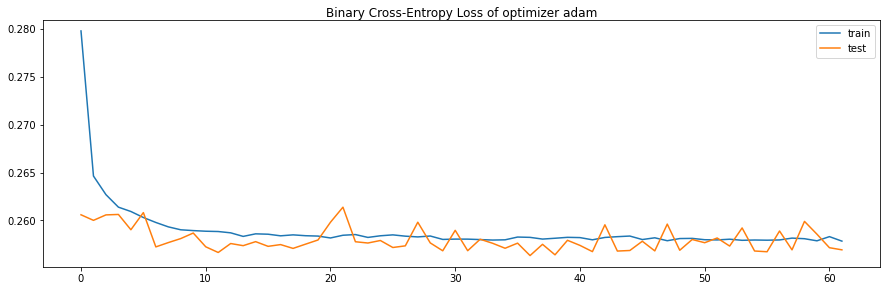

In [285]:
plot_loss(history, optimizers[3])

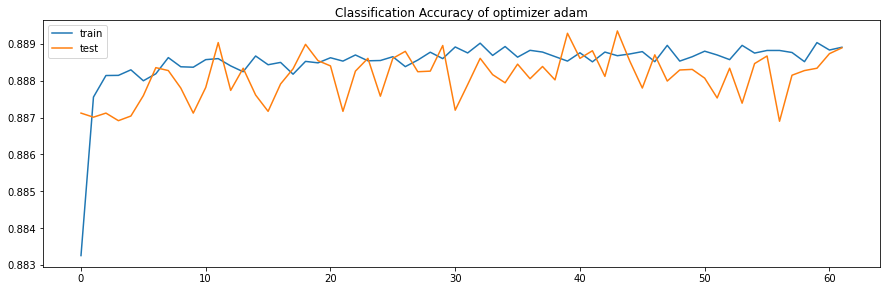

In [286]:
plot_accuracy(history, optimizers[3])

In [287]:
predictions = model.predict_classes(X_test_norm)

In [288]:
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

0.6200721519537532
0.8894160214564041


In [289]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63623
           1       0.94      0.46      0.62     15421

    accuracy                           0.89     79044
   macro avg       0.91      0.73      0.78     79044
weighted avg       0.89      0.89      0.87     79044



In [290]:
print(confusion_matrix(y_test, predictions))

[[63170   453]
 [ 8288  7133]]


In [210]:
#plot_confusion_matrix(model, X_test_norm, y_test, values_format='d', display_labels=["Paid","Not Paid"]);

### Optimizing Adam with LearningRateScheduler (step_decay)

Default parameers: 
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,

In [306]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list.append(lrate)

In [307]:
init_time = datetime.now()
opt = Adam(learning_rate=0.1)
model = create_batch_normalization_model(opt)
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7874/7905 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8631
Epoch 00001: val_accuracy improved from -inf to 0.84646, saving model to weights.best.hdf5
7905/7905 [==============================] - 13s 2ms/step - loss: 0.3518 - accuracy: 0.8631 - val_loss: 0.4450 - val_accuracy: 0.8465
Epoch 2/600
7885/7905 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.8649
Epoch 00002: val_accuracy improved from 0.84646 to 0.87690, saving model to weights.best.hdf5
7905/7905 [==============================] - 16s 2ms/step - loss: 0.3483 - accuracy: 0.8649 - val_loss: 0.3350 - val_accuracy: 0.8769
Epoch 3/600
7905/7905 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8657
Epoch 00003: val_accuracy did not improve from 0.87690
7905/7905 [==============================] - 16s 2ms/step - loss: 0.3465 - accuracy: 0.8657 - val_loss: 35.7169 - val_accuracy: 0.1989
Epoch 4/600
7880/7905 [============================>.] - ETA

In [308]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Training Loss: 0.804 Validation Accuracy:0.801


In [ ]:
plot_loss(history, optimizers[3])

In [ ]:
plot_accuracy(history, optimizers[3])

In [297]:
predictions = model.predict_classes(X_test_norm)

In [298]:
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

0.0
0.804906128232377


In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
print(confusion_matrix(y_test, predictions))

### Optimizing Adam with LearningRateScheduler (Exponential Decay)

In [330]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate

lrate = LearningRateScheduler(exp_decay)
callbacks_list.append(lrate)

In [331]:
init_time = datetime.now()
opt = Adam(learning_rate=0.1)
model = create_batch_normalization_model(opt)
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7880/7905 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8644
Epoch 00001: val_accuracy improved from -inf to 0.84112, saving model to weights.best.hdf5
7905/7905 [==============================] - 13s 2ms/step - loss: 0.3491 - accuracy: 0.8644 - val_loss: 0.4580 - val_accuracy: 0.8411
Epoch 2/600
7890/7905 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8660
Epoch 00002: val_accuracy did not improve from 0.84112
7905/7905 [==============================] - 13s 2ms/step - loss: 0.3461 - accuracy: 0.8660 - val_loss: 8.0028 - val_accuracy: 0.8011
Epoch 3/600
7880/7905 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8233
Epoch 00003: val_accuracy did not improve from 0.84112
7905/7905 [==============================] - 15s 2ms/step - loss: 0.4505 - accuracy: 0.8233 - val_loss: 0.4996 - val_accuracy: 0.8011
Epoch 4/600
7884/7905 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.8043
E

In [332]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Training Loss: 0.804 Validation Accuracy:0.801


### Resampling with Batch Normalization & kernel_constraint (max_norm)

In [39]:
init_time = datetime.now()
#resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) 
#Training Loss: 0.859 Validation Accuracy:0.841 
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# fit and apply the transform
X_sample, y_sample = resample.fit_resample(X_train_norm, y_train)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Execution time :  2:19:44.264295


In [58]:
init_time = datetime.now()
optimizer = Adam()
model = create_batch_normalization_model(optimizer)
history = model.fit(x=X_sample, 
                    y=y_sample, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
10763/10784 [============================>.] - ETA: 0s - loss: 0.2622 - accuracy: 0.8738
Epoch 00001: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 16s 1ms/step - loss: 0.2622 - accuracy: 0.8739 - val_loss: 0.5362 - val_accuracy: 0.7302
Epoch 2/600
10766/10784 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.8864
Epoch 00002: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 19s 2ms/step - loss: 0.2383 - accuracy: 0.8864 - val_loss: 0.5587 - val_accuracy: 0.7209
Epoch 3/600
10764/10784 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.8907
Epoch 00003: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 19s 2ms/step - loss: 0.2313 - accuracy: 0.8907 - val_loss: 0.5768 - val_accuracy: 0.7030
Epoch 4/600
10773/10784 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.8931
Epoch 00004: val_accura

Epoch 29/600
10779/10784 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9081
Epoch 00029: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 20s 2ms/step - loss: 0.2031 - accuracy: 0.9081 - val_loss: 0.4915 - val_accuracy: 0.7602
Epoch 30/600
10774/10784 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9090
Epoch 00030: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 20s 2ms/step - loss: 0.2021 - accuracy: 0.9090 - val_loss: 0.5224 - val_accuracy: 0.7451
Epoch 31/600
10757/10784 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9082
Epoch 00031: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 20s 2ms/step - loss: 0.2018 - accuracy: 0.9082 - val_loss: 0.5334 - val_accuracy: 0.7392
Epoch 32/600
10763/10784 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9091
Epoch 00032: val_ac

Epoch 57/600
10764/10784 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9124
Epoch 00057: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 20s 2ms/step - loss: 0.1955 - accuracy: 0.9124 - val_loss: 0.5280 - val_accuracy: 0.7493
Epoch 58/600
10764/10784 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9125
Epoch 00058: val_accuracy did not improve from 0.88957
10784/10784 [==============================] - 22s 2ms/step - loss: 0.1954 - accuracy: 0.9124 - val_loss: 0.5748 - val_accuracy: 0.7332
Epoch 00058: early stopping
Execution time :  0:19:35.773169


In [59]:
evaluate_model(X_sample, y_sample, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Training Loss: 0.918 Validation Accuracy:0.733


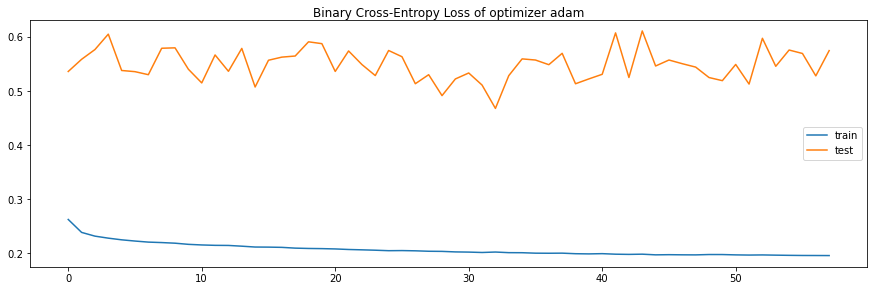

In [60]:
plot_loss(history, optimizers[3])

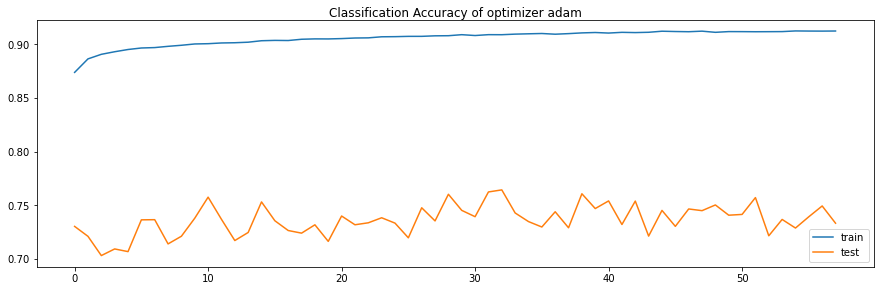

In [61]:
plot_accuracy(history, optimizers[3])

In [62]:
predictions = model.predict_classes(X_test_norm)

In [63]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     63623
           1       0.41      0.87      0.55     15421

    accuracy                           0.73     79044
   macro avg       0.68      0.78      0.68     79044
weighted avg       0.85      0.73      0.75     79044



In [64]:
print(confusion_matrix(y_test, predictions))

[[44084 19539]
 [ 2040 13381]]


### Experiment with Activity Regularization (L1) & Weight Regularization (L2) 
[0.100000, 0.010000, 0.001000, 0.000100, 0.000010, 0.000001]

In [196]:
def create_model_with_L1L2():
    # create model
    model = Sequential()
   
    # Hidden Layers
    #model.add(Dense(32, activation='linear', activity_regularizer=l1(0.001)))
    #model.add(Activation('relu'))
    #model.add(Dense(82, input_dim=n_input, activation='linear', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(GaussianNoise(0.01, input_shape=(2,)))
    #model.add(Dense(500, activation='relu'))
    
    model.add(Dense(82, input_dim=n_input, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Dense(82, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(41, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(41, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(21, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(21, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [197]:
init_time = datetime.now()
model = create_model_with_L1L2()
history = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7899/7905 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8801
Epoch 00001: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 14s 2ms/step - loss: 0.2888 - accuracy: 0.8801 - val_loss: 0.2622 - val_accuracy: 0.8869
Epoch 2/600
7901/7905 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.8878
Epoch 00002: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 16s 2ms/step - loss: 0.2653 - accuracy: 0.8878 - val_loss: 0.2610 - val_accuracy: 0.8870
Epoch 3/600
7896/7905 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.8878
Epoch 00003: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 16s 2ms/step - loss: 0.2632 - accuracy: 0.8878 - val_loss: 0.2594 - val_accuracy: 0.8870
Epoch 4/600
7905/7905 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8879
Epoch 00004: val_accuracy did not imp

Epoch 30/600
7902/7905 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8906
Epoch 00030: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 19s 2ms/step - loss: 0.2520 - accuracy: 0.8906 - val_loss: 0.2563 - val_accuracy: 0.8894
Epoch 31/600
7899/7905 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8905
Epoch 00031: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 19s 2ms/step - loss: 0.2518 - accuracy: 0.8905 - val_loss: 0.2558 - val_accuracy: 0.8888
Epoch 32/600
7885/7905 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8905
Epoch 00032: val_accuracy did not improve from 0.88992
7905/7905 [==============================] - 19s 2ms/step - loss: 0.2518 - accuracy: 0.8905 - val_loss: 0.2563 - val_accuracy: 0.8889
Epoch 33/600
7892/7905 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.8908
Epoch 00033: val_accuracy did not

In [198]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])
#Training Loss: 0.892 Validation Accuracy:0.889

Optimizer: adam Training Loss: 0.894 Validation Accuracy:0.888


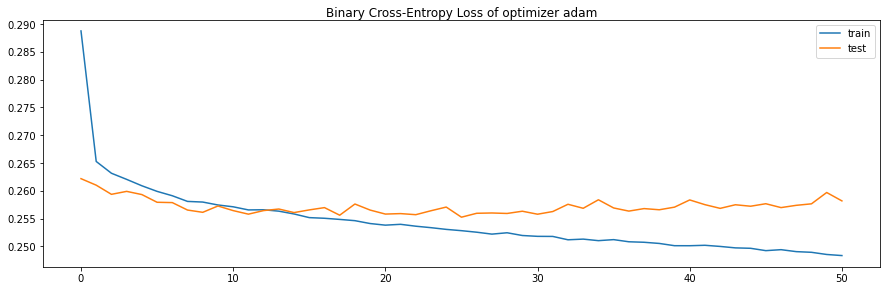

In [199]:
plot_loss(history, optimizers[3])

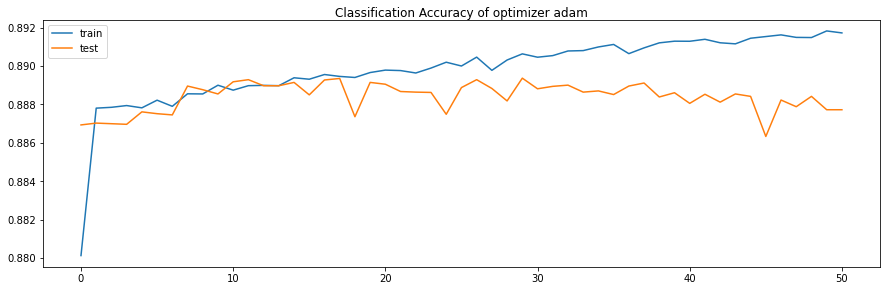

In [200]:
plot_accuracy(history, optimizers[3])

In [201]:
predictions = model.predict_classes(X_test_norm)

In [202]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     63623
           1       0.90      0.48      0.63     15421

    accuracy                           0.89     79044
   macro avg       0.90      0.73      0.78     79044
weighted avg       0.89      0.89      0.87     79044



In [203]:
print(confusion_matrix(y_test, predictions))
#[[63021   602]
# [ 8146  7275]]

[[62832   791]
 [ 7993  7428]]


### Experiment with Noise Regularization

In [24]:
def create_model_with_noise():
    # create model
    model = Sequential()
   
    # Hidden Layers
    #model.add(Dense(32, activation='linear', activity_regularizer=l1(0.001)))
    #model.add(Activation('relu'))
    #model.add(Dense(82, input_dim=n_input, activation='linear', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(GaussianNoise(0.01, input_shape=(2,)))
    #model.add(Dense(500, activation='relu'))
    
    model.add(GaussianNoise(0.01, input_shape=(n_input,)))
    #model.add(Dense(164, input_dim=n_input, activation='relu', kernel_regularizer=L1L2(l1=0.000001, l2=0.0)))
    model.add(Dense(164, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Dense(164, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(82, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(82, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(41, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(41, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(21, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(21, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=0.0)))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [27]:
init_time = datetime.now()
model = create_model_with_noise()
history_sampling = model.fit(x=X_train_norm, 
                    y=y_train, 
                    epochs=600,
                    batch_size=32,
                    validation_data=(X_valid_norm, y_valid), verbose=1,
                    callbacks=callbacks_list
                   )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Epoch 1/600
7896/7905 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8805
Epoch 00001: val_accuracy improved from -inf to 0.88247, saving model to weights.best.hdf5
7905/7905 [==============================] - 26s 3ms/step - loss: 0.2877 - accuracy: 0.8804 - val_loss: 0.2654 - val_accuracy: 0.8825
Epoch 2/600
7902/7905 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.8875
Epoch 00002: val_accuracy improved from 0.88247 to 0.88702, saving model to weights.best.hdf5
7905/7905 [==============================] - 30s 4ms/step - loss: 0.2663 - accuracy: 0.8875 - val_loss: 0.2605 - val_accuracy: 0.8870
Epoch 3/600
7904/7905 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8876
Epoch 00003: val_accuracy did not improve from 0.88702
7905/7905 [==============================] - 32s 4ms/step - loss: 0.2643 - accuracy: 0.8876 - val_loss: 0.2614 - val_accuracy: 0.8869
Epoch 4/600
7894/7905 [============================>.] - ETA:

Epoch 29/600
7904/7905 [============================>.] - ETA: 0s - loss: 0.2539 - accuracy: 0.8898
Epoch 00029: val_accuracy did not improve from 0.88886
7905/7905 [==============================] - 34s 4ms/step - loss: 0.2540 - accuracy: 0.8898 - val_loss: 0.2582 - val_accuracy: 0.8882
Epoch 30/600
7902/7905 [============================>.] - ETA: 0s - loss: 0.2539 - accuracy: 0.8897
Epoch 00030: val_accuracy did not improve from 0.88886
7905/7905 [==============================] - 33s 4ms/step - loss: 0.2539 - accuracy: 0.8897 - val_loss: 0.2595 - val_accuracy: 0.8876
Epoch 31/600
7898/7905 [============================>.] - ETA: 0s - loss: 0.2533 - accuracy: 0.8900
Epoch 00031: val_accuracy did not improve from 0.88886
7905/7905 [==============================] - 35s 4ms/step - loss: 0.2534 - accuracy: 0.8900 - val_loss: 0.2593 - val_accuracy: 0.8878
Epoch 32/600
7899/7905 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.8900
Epoch 00032: val_accuracy did not

In [28]:
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, model, optimizers[3])

Optimizer: adam Training Loss: 0.893 Validation Accuracy:0.888


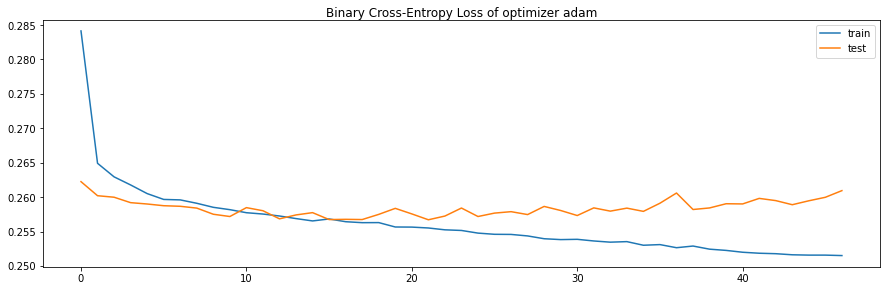

In [183]:
plot_loss(history_sampling, optimizers[3])

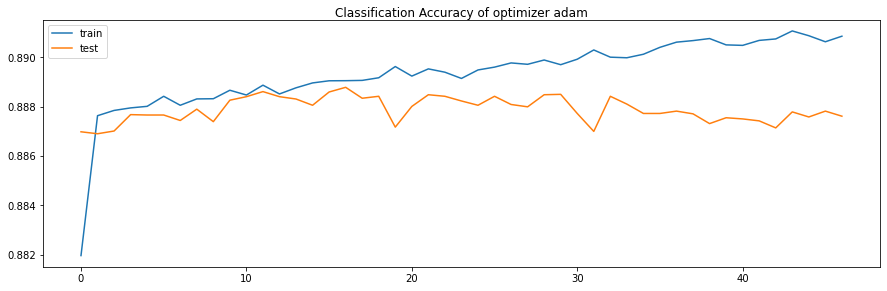

In [184]:
plot_accuracy(history_sampling, optimizers[3])

In [186]:
predictions = model.predict_classes(X_test_norm)

In [187]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63623
           1       0.93      0.47      0.62     15421

    accuracy                           0.89     79044
   macro avg       0.91      0.73      0.78     79044
weighted avg       0.89      0.89      0.87     79044



In [188]:
print(confusion_matrix(y_test, predictions))

[[63082   541]
 [ 8226  7195]]


### Load the Saved Model

In [191]:
# load the saved model
saved_model = load_model('weights.best.hdf5')

In [192]:
# evaluate the model
evaluate_model(X_train_norm, y_train, X_valid_norm, y_valid, saved_model, optimizers[3])

Optimizer: adam Training Loss: 0.891 Validation Accuracy:0.890


In [193]:
predictions = saved_model.predict_classes(X_test_norm)

In [194]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63623
           1       0.94      0.46      0.62     15421

    accuracy                           0.89     79044
   macro avg       0.91      0.73      0.78     79044
weighted avg       0.90      0.89      0.87     79044



In [195]:
print(confusion_matrix(y_test, predictions))

[[63187   436]
 [ 8318  7103]]
